In [1]:
pip install wfdb

  Using cached wfdb-4.1.2-py3-none-any.whl.metadata (4.3 kB)
  Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl.metadata (14 kB)
Using cached wfdb-4.1.2-py3-none-any.whl (159 kB)
Using cached soundfile-0.12.1-py2.py3-none-manylinux_2_31_x86_64.whl (1.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import ast
import seaborn as sns
import numpy as np
import scipy.signal as sgn
from wfdb import processing

In [3]:
model_predictions = pd.read_csv('results_ptbXL_age_6diseases.csv')
metadata = pd.read_csv('ptbxl_database.csv')

# Read Feature Dataset and extract PR interval, QRS duration (both as global parameter for all leads) and the area for the T-wave particularly for lead V1 
Features1 = pd.read_csv('12sl_features.csv')
Features1 = Features1[['ecg_id', 'PR_Int_Global', 'QRS_Dur_Global', 'T_Area_V1']] 

model_predictions.head()

ECG_id  Pat_id         1dAVb          RBBB          LBBB            SB  \
0  06217_hr  6217.0  7.114050e-06  8.504063e-09  3.287802e-09  7.889042e-09   
1  06540_hr  6540.0  9.273811e-03  1.264315e-05  8.813035e-01  1.086542e-06   
2  06910_hr  6910.0  3.569890e-03  1.041119e-05  2.068239e-05  3.442387e-07   
3  06481_hr  6481.0  1.885293e-03  9.935911e-08  6.854291e-08  3.304129e-08   
4  06948_hr  6948.0  1.382462e-08  1.013484e-11  5.030062e-12  1.048950e-10   

             AF            ST  
0  8.464745e-06  1.302574e-07  
1  7.011396e-04  1.446912e-05  
2  1.148417e-03  1.921427e-06  
3  3.307923e-04  4.062014e-07  
4  1.368968e-09  7.598758e-11

In [4]:
#Get Model Predictions
model_predictions['ecg_id'] = model_predictions['ECG_id'].str[:-3].astype(int)
model_predictions = model_predictions[['ecg_id', 'RBBB', 'LBBB']]
model_predictions = model_predictions.rename(columns={'RBBB': 'RBBB_prediction'})
model_predictions = model_predictions.rename(columns={'LBBB': 'LBBB_prediction'})
model_predictions.head()

ecg_id  RBBB_prediction  LBBB_prediction
0    6217     8.504063e-09     3.287802e-09
1    6540     1.264315e-05     8.813035e-01
2    6910     1.041119e-05     2.068239e-05
3    6481     9.935911e-08     6.854291e-08
4    6948     1.013484e-11     5.030062e-12

In [5]:
#Get the data where human validated first degree av block, complete left bundle brach block & complete right bundle branch block are present
metadata['scp_codes'] = metadata['scp_codes'].apply(ast.literal_eval)
metadata['CLBBB'] = metadata.apply(lambda row: 1 if ('CLBBB' in row['scp_codes'] and row['scp_codes']['CLBBB'] == 100 and row['validated_by_human']) else 0, axis=1)
metadata['CRBBB'] = metadata.apply(lambda row: 1 if ('CRBBB' in row['scp_codes'] and row['scp_codes']['CRBBB'] == 100 and row['validated_by_human']) else 0, axis=1)

metadata = metadata[['ecg_id', 'age', 'sex', 'CRBBB', 'CLBBB', 'validated_by_human']]

bbb_counts = metadata[['CRBBB', 'CLBBB']].sum()
bbb_counts

CRBBB    372
CLBBB    291
dtype: int64

In [6]:
#merge the prepared df for further processing
meta_prediction = pd.merge(model_predictions, metadata, on='ecg_id', how='left')
meta_prediction_feature1 = pd.merge(meta_prediction, Features1, on='ecg_id', how='left')

sensitivity_CLBBB:  0.9862542955326461
specificity_CLBBB:  0.9793847129717729


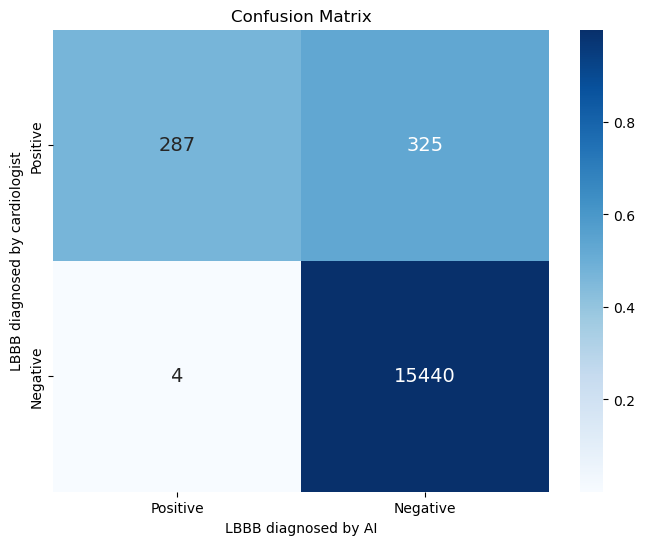

In [7]:
#Calculate sensitivity/ specificity for model's capability in predicting LBBBs
#True Positive Complete LBBB 
TP_CLBBB = len(meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.05) 
                               & (meta_prediction_feature1['CLBBB'] == 1)])
#False Negative Complete LBBB 
FN_CLBBB = len(meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] < 0.05) 
                               & (meta_prediction_feature1['CLBBB'] == 1)])
#Print sensitivity
sensitivity_CLBBB = TP_CLBBB/(TP_CLBBB+FN_CLBBB)
print('sensitivity_CLBBB: ', sensitivity_CLBBB)

#True Negative
TN_CLBBB = len(meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] < 0.05) 
                               & (meta_prediction_feature1['CLBBB'] == 0) & (meta_prediction_feature1['validated_by_human'] ==True )])
#False Positive
FP_CLBBB = len(meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.05) 
                               & (meta_prediction_feature1['CLBBB'] == 0) & (meta_prediction_feature1['validated_by_human'] ==True )])
#Print specificity
specificity_CLBBB = TN_CLBBB/(TN_CLBBB+FP_CLBBB)
print('specificity_CLBBB: ', specificity_CLBBB)

# Create a 2x2 confusion matrix
confusion_matrix = np.array([[TP_CLBBB, FP_CLBBB], [FN_CLBBB, TN_CLBBB]])
confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Labels for the classes
class_labels = ['Positive', 'Negative']

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_normalized, annot=confusion_matrix, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"size": 14})

# Adding labels and title for clarity
plt.ylabel('LBBB diagnosed by cardiologist')
plt.xlabel('LBBB diagnosed by AI')
plt.title('Confusion Matrix')
plt.show()

sensitivity_CRBBB:  0.989247311827957
specificity_CRBBB:  0.9862280030604438


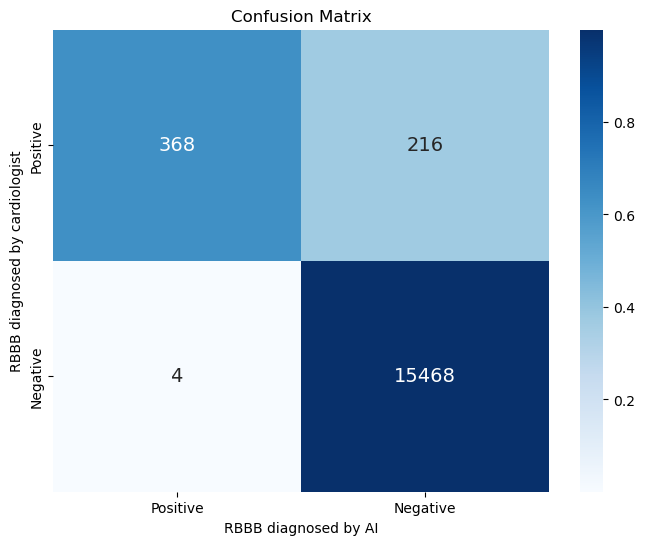

In [8]:
#Calculate sensitivity/ specificity for model's capability in predicting RBBBs
#True Positive Compelte RBBB 
TP_CRBBB = len(meta_prediction_feature1[(meta_prediction_feature1['RBBB_prediction'] > 0.05) 
                               & (meta_prediction_feature1['CRBBB'] == 1)])
#False Negative Complete RBBB
FN_CRBBB = len(meta_prediction_feature1[(meta_prediction_feature1['RBBB_prediction'] < 0.05) 
                               & (meta_prediction_feature1['CRBBB'] == 1)])
#Print sensitivity
sensitivity_CRBBB = TP_CRBBB/(TP_CRBBB+FN_CRBBB)
print('sensitivity_CRBBB: ', sensitivity_CRBBB)

#True Negative Complete RBBB
TN_CRBBB = len(meta_prediction_feature1[(meta_prediction_feature1['RBBB_prediction'] < 0.05) 
                               & (meta_prediction_feature1['CRBBB'] == 0) & (meta_prediction_feature1['validated_by_human'] ==True )])
#False Positive Complete RBBB
FP_CRBBB = len(meta_prediction_feature1[(meta_prediction_feature1['RBBB_prediction'] > 0.05) 
                               & (meta_prediction_feature1['CRBBB'] == 0) & (meta_prediction_feature1['validated_by_human'] ==True )])
#Print specificity
specificity_CRBBB = TN_CRBBB/(TN_CRBBB+FP_CRBBB)
print('specificity_CRBBB: ', specificity_CRBBB)
# Create a 2x2 confusion matrix
confusion_matrix = np.array([[TP_CRBBB, FP_CRBBB], [FN_CRBBB, TN_CRBBB]])
confusion_matrix_normalized = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

# Labels for the classes
class_labels = ['Positive', 'Negative']

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_normalized, annot=confusion_matrix, fmt='d', cmap='Blues', cbar=True,
            xticklabels=class_labels, yticklabels=class_labels,
            annot_kws={"size": 14})

# Adding labels and title for clarity
plt.ylabel('RBBB diagnosed by cardiologist')
plt.xlabel('RBBB diagnosed by AI')
plt.title('Confusion Matrix')
plt.show()

In [9]:
#Calculate specificity for QRS duration over 120ms in predicted BBBs
#True Negative Complete LBBB 
TN_CLBBB = len(meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] < 0.05) & (meta_prediction_feature1['QRS_Dur_Global'] < 120)])
#False Positive Complete LBBB 
FP_CLBBB = len(meta_prediction_feature1[(meta_prediction_feature1['LBBB_prediction'] > 0.05) & (meta_prediction_feature1['QRS_Dur_Global'] < 120)])
#Print specificity for broad QRS
specificity_CLBBB = TN_CLBBB/(TN_CLBBB+FP_CLBBB)
print('specificity_CLBBB_broad_QRS: ', specificity_CLBBB)
#True Negative Complete RBBB 
TN_CRBBB = len(meta_prediction_feature1[(meta_prediction_feature1['RBBB_prediction'] < 0.05) & (meta_prediction_feature1['QRS_Dur_Global'] < 120)])
#False Positive Complete RBBB 
FP_CRBBB = len(meta_prediction_feature1[(meta_prediction_feature1['RBBB_prediction'] > 0.05) & (meta_prediction_feature1['QRS_Dur_Global'] < 120)])
#Print specificity for broad QRS
specificity_CRBBB = TN_CRBBB/(TN_CRBBB+FP_CRBBB)
print('specificity_CRBBB_broad_QRS: ', specificity_CRBBB)

specificity_CLBBB_broad_QRS:  0.9950162733930025
specificity_CRBBB_broad_QRS:  0.9951179820992677


In [10]:
#Get age and gender distribution for human validated subset
metadata['age'] = metadata['age'].replace(300, 90)
human_validated = metadata[['age', 'sex', 'CRBBB', 'CLBBB', 'validated_by_human']]
print(len(human_validated))
human_validated = human_validated[human_validated['validated_by_human']==True]
print(len(human_validated))
age_distribution = human_validated['age'].describe()
gender_distribution = human_validated['sex'].sum()/len(human_validated)*100
print("Age Distribution:\n", age_distribution)
print(gender_distribution, '% are woman')

21799
16056
Age Distribution:
 count    16056.000000
mean        60.851084
std         18.240859
min          2.000000
25%         49.000000
50%         64.000000
75%         75.000000
max         90.000000
Name: age, dtype: float64
53.12655705032386 % are woman


In [11]:
#Get age and gender distribution for human validated LBBB
print(len(human_validated))
LBBB = human_validated[human_validated['CLBBB']==1]
print(len(LBBB))
age_distribution = LBBB['age'].describe()
gender_distribution = LBBB['sex'].sum()/len(LBBB)*100
print("Age Distribution:\n", age_distribution)
print(gender_distribution, '% are woman')

16056
291
Age Distribution:
 count    291.000000
mean      75.735395
std       11.037651
min       25.000000
25%       69.000000
50%       77.000000
75%       84.000000
max       90.000000
Name: age, dtype: float64
58.76288659793815 % are woman


In [12]:
#Get age and gender distribution for human validated LBBB
print(len(human_validated))
RBBB = human_validated[human_validated['CRBBB']==1]
print(len(RBBB))
age_distribution = RBBB['age'].describe()
gender_distribution = RBBB['sex'].sum()/len(RBBB)*100
print("Age Distribution:\n", age_distribution)
print(gender_distribution, '% are woman')

16056
372
Age Distribution:
 count    372.000000
mean      74.190860
std       11.161332
min       23.000000
25%       67.000000
50%       76.000000
75%       83.000000
max       90.000000
Name: age, dtype: float64
36.29032258064516 % are woman


In [13]:
def normalize_relevances_quartile(relevances, quartile=0.03):
    """
    Normalize the results of an XAI approach between -1 and 1 using IQR for robustness;
    the input are the relevances indicating which part of the ECG was important for the model's decision making;
    relevances has to have the identical shape like the ECG.
    """
    # Calculate negative and positive quartile
    quartile_neg = np.percentile(relevances, quartile)
    quartile_pos = np.percentile(relevances, 100-quartile)
    abs_quartile = np.array([abs(quartile_neg), quartile_pos]).max()
    # Apply normalization based on absolute quartile 
    normalized_relevances = relevances/ abs_quartile
    normalized_relevances = np.clip(normalized_relevances, -1, 1)
    return normalized_relevances

#patient can be the 'healthy' or the 'lbbb' test patient
patient='lbbb'
#load XAI relevances
test = np.load(f'{patient}.npz')
pat_id = test['pat_id']
ig_relevances_LBBB = test['ig_relevances_LBBB']
#relevances_RBBB = np.squeeze(test['relevances_RBBB'][0]).transpose()
prediction_6disease = test['prediction_6disease']
test.close()

#load ECG data (can be healthy or LBBB)
data = wfdb.rdrecord(patient)
ECG = data.p_signal.T
current_channels = data.sig_name
#security check for correct order of channels
if current_channels != ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']:
    print(f'Cave: order of channels have to be adjusted for {recording} since there are in order {current_channels}')
sampling_rate = data.fs
ECG_resampled = np.array([sgn.resample_poly(ECG, up=400, down=sampling_rate, axis=-1).astype(np.float32)])
pad=48
if np.shape(ECG_resampled)[2]==4002:
    pad=47
padding = ((0, 0), (0, 0), (pad, pad))
ECG_resampled = np.pad(ECG_resampled, padding, mode='constant', constant_values=0)[0]

In [14]:
relevances = normalize_relevances_quartile(ig_relevances_LBBB, quartile=0.03)

In [15]:
r_peaks=[]
for y in range(12):
    # Delineate the ECG signal and visualizing all peaks of ECG complexes
    xqrs = processing.XQRS(sig=ECG_resampled[y], fs=400)
    xqrs.detect()
    print(xqrs.qrs_inds)
    r_peaks.append(xqrs.qrs_inds)

def majority_vote(leads, tolerance=10, majority_threshold=None):
    if majority_threshold is None:
        majority_threshold = len(leads) // 2 + 1  # Simple majority

    # Flatten the list and sort
    all_peaks = np.sort(np.concatenate(leads))
    
    # Initialize an array to keep track of votes for each R peak
    votes = np.zeros(len(all_peaks), dtype=int)
    
    # Iterate through all R peaks and count votes
    for i, peak in enumerate(all_peaks):
        for lead in leads:
            # Count how many peaks in this lead are within the tolerance window of the current peak
            votes[i] += np.sum(np.abs(lead - peak) <= tolerance)
    
    # Filter peaks based on majority vote
    valid_peaks = all_peaks[votes >= majority_threshold]
    
    # Deduplicate peaks within tolerance (since multiple close peaks could have passed the threshold)
    deduped_peaks = []
    last_peak = None
    for peak in valid_peaks:
        if last_peak is None or peak - last_peak > tolerance:
            deduped_peaks.append(peak)
            last_peak = peak
    
    return np.array(deduped_peaks).astype(int)

# Compute the majority vote
validated_peaks = majority_vote(r_peaks, majority_threshold=5)
print("Validated R peaks:", validated_peaks)

Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[]
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[ 129  578  914 1248 1549 1915 2244 2580 2897 3273 3618 3967]
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[ 129  578  914 1248 1548 1915 2244 2580 2897 3273 3618 3967]
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[]
Learning initial signal parameters...
Failed to find 8 beats during learning.
Initializing using default parameters
Running QRS detection...
QRS detection complete.
[ 129  578  914 1248 1548 1915 2244 2580 2896

In [16]:
names = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
# Calculation the lead importancy for positive relevances
negative_mask = relevances < 0
relevances[negative_mask] = 0    
leads =[]
for i in range(len(relevances)):
    leads.append(relevances[i].sum())
overall_relevances=sum(leads)
for y in range(len(leads)):
    print(f'The lead importancy for {names[y]} was {leads[y]/overall_relevances*100} %.')
# Define the region of interest for LBBB as 40ms before and 120ms after the r peak
QRS=[]
for l in range(len(relevances)):
    leadwise_relevances=[]
    current_lead = relevances[l]    
    for r_peak in range(len(validated_peaks)):
        leadwise_relevances.append(current_lead[validated_peaks[r_peak]-40:validated_peaks[r_peak]+120].sum())
    QRS.append(sum(leadwise_relevances))
print(f'The defined region of interest in all leads was {np.round(len(validated_peaks)*160/4096*100, 2)} % of the signal but contain {np.round(sum(QRS)/overall_relevances*100, 2)}% of the relevances.')
print(f'The defined region of interest in V1-V6 was {np.round(len(validated_peaks)*160/4096*100/2, 2)} % of the signal but contain {np.round(sum(QRS[7:])/overall_relevances*100, 2)}% of the relevances.')
print(f'The defined region of interest in V1-V3 was {np.round(len(validated_peaks)*160/4096*100/4, 2)} % of the signal but contain {np.round(sum(QRS[7:10])/overall_relevances*100, 2)}% of the relevances.')


The lead importancy for I was 2.9821173021865444 %.
The lead importancy for II was 7.808304393010847 %.
The lead importancy for III was 2.674786993900017 %.
The lead importancy for AVR was 6.03773139788461 %.
The lead importancy for AVL was 0.8115158774887381 %.
The lead importancy for AVF was 3.976086968834416 %.
The lead importancy for V1 was 25.188323819442605 %.
The lead importancy for V2 was 16.943064695741878 %.
The lead importancy for V3 was 14.954656682399541 %.
The lead importancy for V4 was 5.51452971304469 %.
The lead importancy for V5 was 6.107210512757753 %.
The lead importancy for V6 was 7.001671643308363 %.
The defined region of interest in all leads was 46.88 % of the signal but contain 79.37% of the relevances.
The defined region of interest in V1-V6 was 23.44 % of the signal but contain 43.04% of the relevances.
The defined region of interest in V1-V3 was 11.72 % of the signal but contain 31.4% of the relevances.


In [17]:
TP_region = pd.read_csv('results_lead_QRS.csv', names=['ECG_id', 'leads', 'regions'])
TP_region['leads'] = TP_region['leads'].apply(ast.literal_eval)
TP_region['regions'] = TP_region['regions'].apply(ast.literal_eval)
TP_region['leads'] = TP_region['leads'].apply(lambda x: [float(i) for i in x])
TP_region['regions'] = TP_region['regions'].apply(lambda x: [float(i) for i in x])
TP_region

ECG_id                                              leads  \
0     15129  [30.955524, 51.97619, 41.734116, 29.288807, 20...   
1     19974  [61.4085, 72.30484, 70.132706, 48.703247, 48.6...   
2      3932  [82.70744, 59.38978, 36.617672, 57.765686, 29....   
3     11474  [88.240685, 47.95975, 56.58544, 45.590103, 45....   
4      2988  [144.76357, 52.40131, 45.708267, 84.53619, 49....   
..      ...                                                ...   
282   19443  [33.90683, 70.726974, 48.924423, 45.233162, 22...   
283    3484  [104.19824, 42.945602, 68.0927, 53.627983, 55....   
284    8018  [59.091064, 51.926636, 81.18837, 27.69278, 57....   
285    5872  [79.28998, 76.85838, 71.529236, 65.07434, 40.5...   
286   10130  [92.64598, 68.83205, 42.545937, 75.498146, 31....   

                                               regions  
0    [16.64299714565277, 27.65728485584259, 27.8961...  
1    [50.53202097117901, 62.63201725482941, 64.5274...  
2    [89.14664578437805, 41.38246130943298, 30.6476...  
3    [76.6749439239502, 31.72884976863861, 45.74565...  
4    [237.93038845062256, 64.30183529853821, 65.035...  
..                                                 ...  
282  [42.86197692155838, 121.48940575122833, 92.755...  
283  [162.0709924697876, 57.107529282569885, 106.65...  
284  [95.3081978559494, 80.11880823969841, 139.4587...  
285  [52.94540309906006, 40.676557779312134, 50.228...  
286  [79.81300902366638, 48.08313751220703, 37.7229...  

[287 rows x 3 columns]

In [18]:
# Compute the relevance for the leads and regions of all TP classified patients
region_relevance_average = []
lead_relevance_average = np.zeros(12)

for i in range(len(TP_region)):
    leads = TP_region['leads'][i]
    region = TP_region['regions'][i]
    #security check for false detected r_peaks or tachykardia
    for y in range(12):
        if leads[y] < region[y]:
            leads[y] = region[y]
    overall_relevances=sum(leads)
    region_relevance_average.append(sum(region)/overall_relevances*100)
    lead_importancy= np.zeros(12)
    for l in range(12):
        lead_importancy[l]=leads[l]/overall_relevances*100
    lead_relevance_average = lead_relevance_average+lead_importancy
lead_relevance_average = lead_relevance_average/len(TP_region)
region_relevance_average = sum(region_relevance_average)/len(TP_region)
print('Lead importancy', lead_relevance_average)
print('How often were the relevances on the region of interest:', region_relevance_average, '%')

Lead importancy [ 8.36253389  5.4310325   5.11577858  5.62035546  3.99766935  4.00490691
 25.84802399 14.45233471 13.05858859  4.86255349  4.22595284  5.0202697 ]
How often were the relevances on the region of interest: 83.3445089151174 %
